In [10]:
import matplotlib.pyplot as plt
import numpy as np

# write  to txt file
# for i, j in zip( [t-t[0] for t in trackTimeToRightBin[animal, session][0]], XtrackRunToRightBin[animal, session][0]):
#     for k, l in zip(i, j):
#         print("%.7f %.7f" %(k, l))
#     print()

In [11]:

# Modified from: Averaging GPS segments competition 2019. https://doi.org/10.1016/j.patcog.2020.107730
#                T. Karasek, "SEGPUB.IPYNB", Github, 2019. https://gist.github.com/t0mk/eb640963d7d64e14d69016e5a3e93fd6

def read_training(gl):
    tr = {}
    #for file in glob.glob(gl):
    file = gl    
    # = int(file.split("/")[1].split(".")[0])
    with open(file) as f:
        fc = f.read()
    ss = fc.split("\n\n")
    ls = []
    ns = 0
    for s in ss:
                    
        tts = s.split("\n")
        xs, ys = [],[]
        for t in tts:
            if not t.strip():
                continue
            x,y = t.strip().split(" ")
            xs.append(float(x))
            ys.append(float(y))
        ls.append((np.array(xs),np.array(ys)))
    tr = ls           
    return tr


def median(lst): 
    sortedLst = sorted(lst)
    lstLen = len(lst)
    index = (lstLen - 1) // 2    
    return sortedLst[index] 

def zscore(l):
    if len(np.unique(l)) == 1:
        return np.full(len(l),0.)
    return (np.array(l)  - np.mean(l)) / np.std(l)
    
def disterr(x1,y1, x2, y2):        
    sd = np.array([x1[0]-x2[0],y1[0]-y2[0]])
    ed = np.array([x1[0]-x2[-1],y1[0]-y2[-1]])
    if np.linalg.norm(sd) > np.linalg.norm(ed):
        x2 = np.flip(x2, axis=0)
        y2 = np.flip(y2, axis=0)
        
    offs = np.linspace(0,1,10)
    xrs1, yrs1 = Traj((x1,y1)).getPoints(offs)
    xrs2, yrs2 = Traj((x2,y2)).getPoints(offs)
    return np.sum(np.linalg.norm([xrs1-xrs2, yrs1-yrs2],axis=0))

def rdp(points, epsilon):
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax >= epsilon:
        results = rdp(points[:index+1], epsilon)[:-1] + rdp(points[index:], epsilon)
    else:
        results = [points[0], points[-1]]
    return results
    
def distance(a, b): 
    return  np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def point_line_distance(point, start, end):
    if (start == end):
        return distance(point, start)
    else:
        n = abs((end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1]))
        d = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        return n / d

class OnlyOnePointError(Exception):
    pass

class SampleSet:
    def __init__(self, ll):
        # ll is list of tuples [x_array,y_array] for every trajectory in sample
        self.trajs = [Traj(l) for l in ll]
        self.xp = None
        self.yp = None
        self.d = None
        self.filtix = None
        self.lenoutix = None
        self.disoutix = None
        self.eps = None

    def getRawAvg(self):
        trajLen = median([len(t.xs) for t in self.trajs])
        offs = np.linspace(0,1,trajLen)
        xm = []
        ym = []
        for t in self.trajs:
            xs, ys = t.getPoints(offs)
            xm.append(xs)
            ym.append(ys)        
        xp, yp = np.median(xm, axis=0), np.median(ym, axis=0)
        #print("xmym", xm, ym)
        #xp, yp = np.mean(xm, axis=0), np.mean(ym, axis=0)
        return xp, yp

    def endpoints(self):
        cs = np.array([[self.trajs[0].xs[0],self.trajs[0].xs[-1]], [self.trajs[0].ys[0],self.trajs[0].ys[-1]]])
        xs = np.hstack([t.xs[0] for t in self.trajs] + [t.xs[-1] for t in self.trajs])
        ys = np.hstack([t.ys[0] for t in self.trajs] + [t.ys[-1] for t in self.trajs])       
        clabs = []
        oldclabs = []
        for j in range(10):
            for i in range(len(xs)):
                ap = np.array([[xs[i]],[ys[i]]])
                dists = np.linalg.norm(ap - cs, axis=0)
                clabs.append(np.argmin(dists))
            #cx = np.array([np.mean(xs[np.where(np.array(clabs)==0)]), np.mean(xs[np.where(np.array(clabs)==1)])])
            #cy = np.array([np.mean(ys[np.where(np.array(clabs)==0)]), np.mean(ys[np.where(np.array(clabs)==1)])])
            if oldclabs == clabs: 
                break
            oldclabs = clabs
            clabs = []
        for i,l in enumerate(clabs[:len(clabs)//2]):
            if l == 1:
                oldT = self.trajs[i]                
                reversedTraj = (np.flip(oldT.xs, axis=0), np.flip(oldT.ys, axis=0))
                self.trajs[i] = Traj(reversedTraj)   

    def zlen(self):
        ls = np.array([t.cuts[-1] for t in self.trajs])
        return zscore(ls)
        
    def getFiltered(self, dismax, lenlim):
        xa, ya = self.getRawAvg()
        d = zscore(np.array([disterr(t.xs, t.ys, xa, ya) for t in self.trajs]))
        l = self.zlen()
        self.lenoutix = np.where((l<lenlim[0])|(l>lenlim[1]))[0]
        lenix = np.where((l>lenlim[0])&(l<lenlim[1]))[0]
        self.disoutix = np.where(d>dismax)[0]
        disix = np.where(d<dismax)[0]
        self.d = d
        self.l = l
        self.filtix = np.intersect1d(lenix,disix)

    def getAvg(self, dismax, lenlim, eps):
        self.eps = eps
        self.endpoints()        
        self.getFiltered(dismax, lenlim)
        atleast = 4
        if len(self.filtix) <= atleast:            
            distrank = np.argsort(self.d)
            self.disoutix = distrank[atleast:]
            self.lenoutix = []
            self.filtix = distrank[:atleast]
        filtered = [self.trajs[i] for i in self.filtix]
        trajLen = median([len(t.xs) for t in filtered])
        offs = np.linspace(0,1,trajLen*10)
        xm = []
        ym = []
        for t in filtered:
            xs, ys = t.getPoints(offs)            
            xm.append(xs)
            ym.append(ys)
        self.xp, self.yp = zip(*rdp(list(zip(np.median(xm, axis=0),np.median(ym, axis=0))), eps))
        #self.xp, self.yp = zip(*rdp(list(zip(np.mean(xm, axis=0),np.mean(ym, axis=0))), eps))
        #self.xp, self.yp = np.mean(xm, axis=0), np.mean(ym, axis=0)
        xp, yp = self.xp,self.yp
        return xp, yp
 
    def pax(self, ax):
        ax.set_xlim(0,2.5)
        ax.set_xticks([])
        ax.set_yticks([])        
        ax.set_ylim(0,130)
        for _, t in enumerate(self.trajs):    
            ax.plot(t.xs,t.ys, c="b", marker="o", markersize=2)
        for n, t in enumerate([self.trajs[i] for i in self.disoutix]):    
            ax.plot(t.xs,t.ys, c="g")
        for n, t in enumerate([self.trajs[i] for i in self.lenoutix]):    
            ax.plot(t.xs,t.ys, c="cyan")
        for n, t in enumerate([self.trajs[i] for i in np.intersect1d(self.lenoutix,self.disoutix)]):    
            ax.plot(t.xs,t.ys, c="magenta")
        if self.xp is not None:
            ax.plot(self.xp,self.yp, marker='D', color='r', linewidth=3)                

class Traj:
    def __init__(self,xsys):
        xs, ys = xsys
        a = np.array(xsys).T
        _, filtered = np.unique(a, return_index=True,axis=0)
        if len(filtered) < 2:
            raise OnlyOnePointError()
        self.xs = np.array(xs)[sorted(filtered)]
        self.ys = np.array(ys)[sorted(filtered)]
        self.xd = np.diff(xs)
        self.yd = np.diff(ys)
        self.dists = np.linalg.norm([self.xd, self.yd],axis=0)
        self.cuts = np.cumsum(self.dists)
        self.d = np.hstack([0,self.cuts])
        
    def getPoints(self, offsets):        
        offdists = offsets * self.cuts[-1]
        ix = np.searchsorted(self.cuts, offdists)        
        offdists -= self.d[ix]
        segoffs = offdists/self.dists[ix]
        x = self.xs[ix] + self.xd[ix]*segoffs
        y = self.ys[ix] + self.yd[ix]*segoffs
        return x,y     



In [12]:
ts = [
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 , 1.44, 1.48, 1.52]),   [3.018874150474649,  3.4724296167247393,    4.197707057976683,    5.17138828631345,    6.33120907494989,    7.646370305637312,    9.1493811644687,    10.912477342855372,    13.010927463989468,    15.494511285955815,    18.36366014764078,    21.565477585857213,    25.02373031951921,    28.679138275220648,    32.50386692497866,    36.48690480121141,    40.61367492690637,    44.860649344373115,    49.20257725224867,    53.6131083529373,    58.05167185095782,    62.454525734163326,    66.74482784564265,    70.85334474119051,    74.73552759946536,    78.38036369005437,    81.80797503825421,    85.0546129881499,    88.15363216890755,    91.12208132111698,    93.95090367245265,    96.59540569146324,    98.97595033460946,    101.00334284065192,    102.6235482793237,    103.8521684513942,    104.77159561971007,    105.49300842977078,    106.1079710793596]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ]),   [4.380536278217821,    4.788314029105829,    5.638998630153673,    7.022030711064973,    8.948145514446324,    11.383698638445425,    14.306547150938357,    17.710474708338786,    21.554891769132805,    25.72823096568969,    30.07725923871527,    34.48363476431334,    38.920482294665945,    43.435134046735,    48.06949462279596,    52.79390710953976,    57.5211593306597,    62.18021563561784,    66.7577405958672,    71.25566115133323,    75.62496374729285,    79.77012801005745,    83.62115992197283,    87.17686967931283,    90.46615842942438,    93.4866642794527,    96.19896696499794,    98.56869968387063,    100.5931613846497,    102.29020944531868,    103.68235641923928,    104.80166915471958,    105.70372152410106,    106.46673706969659,    107.16546741295238,    107.83327659736663]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [6.523473884804286,    6.79067967413523,    7.322280003494649,    8.326740543201083,    9.959046399964047,    12.249554277194333,    15.14046078689279,    18.577170169963345,    22.537542633604215,    26.98082602205518,    31.80452654417268,    36.8713964465579,    42.073544613144556,    47.35941893555095,    52.69544946070744,    58.01304966728068,    63.21333972490761,    68.2261286874984,    73.03946087055535,    77.6519838525129,    82.01313823413204,    86.04058673967981,    89.69538133501553,    93.01086779436969,    96.032809783234,    98.7437500714027,    101.06111878824518,    102.90946716848978,    104.29226606572782,    105.30296270204425,    106.07802529410094,    106.73264459489641]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12]),   [7.072413707328295,    7.4154005574871995,    7.956147816567724,    8.806414535298419,    10.086617297692632,    11.932846831460722,    14.505533095464326,    17.949335438667692,    22.30124850476357,    27.424584800542423,    33.05313861845068,    38.9311425216079,    44.925278346708694,    51.00072136373358,    57.102066887299884,    63.08691547446833,    68.78440805316409,    74.09469370748411,    79.01117711623583,    83.55737368038284,    87.72928562506564,    91.50458874533135,    94.88196266270671,    97.88386380534,    100.51876732881632,    102.75654473451723,    104.55040758563575,    105.88342072803803,    106.79678858793855]), 
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [5.9811746100584955,    6.283450195078439,    6.9673573600569565,    8.230437086424134,    10.201106437355122,    12.913633642872185,    16.356751353951562,    20.507592386092597,    25.293433442622227,    30.55370662457707,    36.0923575793965,    41.779133084436324,    47.571646901487725,    53.42461703550974,    59.206533724460456,    64.7400332594348,    69.92033578274581,    74.76388327103075,    79.33114161505696,    83.62739271177448,    87.60199491911165,    91.22410413549346,    94.51456796454215,    97.49025113533051,    100.10363917616819,    102.26205268701324,    103.90843358534639,    105.08063606172439,    105.89831342078455,    106.4987456642358]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12]),   [7.675980818916927,    8.014403336318253,    8.751174829387043,    10.104014917670707,    12.237674289093109,    15.17606548303825,    18.78872802199531,    22.889605630607313,    27.370375068533228,    32.23513894508949,    37.502163965213086,    43.08931861588923,    48.81389764898377,    54.49889422917967,    60.05917799955092,    65.47559162305943,    70.70622441234097,    75.65836652873648,    80.25865417948856,    84.52388976565686,    88.52844761848483,    92.29587736827685,    95.73822135401184,    98.70625705390103,    101.08926446574455,    102.87216026527321,    104.12796444575162,    104.98075823052913,    105.56842557687712]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [5.767179738661715,    5.947190954362275,    6.426929561626977,    7.4149113411783985,    9.081755801891127,    11.510128952622281,    14.713762728871439,    18.66611808351321,    23.280696772646493,    28.391592328349716,    33.8100067212331,    39.420033636821046,    45.19498847556834,    51.10282188028006,    57.01740032234579,    62.751597051070846,    68.17455763878709,    73.27046786109685,    78.07332230586451,    82.56971897941663,    86.69467928965193,    90.41244081091207,    93.76174187737122,    96.80232323088899,    99.53222221745227,    101.87462565106357,    103.74489373877091,    105.12615166424746,    106.08806719261928,    106.74857004918783]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [6.60332710180731,    7.018322587138394,    7.497913059657474,    8.21307211883376,    9.404876018237301,    11.282935082189386,    13.954766254099873,    17.440722281126437,    21.728057330974337,    26.77389204710458,    32.45255438357575,    38.54040403487753,    44.79517726599159,    51.05867310605461,    57.265959781836926,    63.354972785813715,    69.20054236793302,    74.66332337786676,    79.68568967236459,    84.30479235917886,    88.56526442366055,    92.44180359092425,    95.85722158731112,    98.7561201172723,    101.14111208682098,    103.04887882710995,    104.52048420790544,    105.60715288047078,    106.39233624342357,    106.98749425716471]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [7.269745755481841,    7.80165742057898,    8.520759734942784,    9.42759083520286,    10.61827386049255,    12.39117227695815,    15.188746516041473,    19.28936293514022,    24.50095890529796,    30.239963041522437,    35.96610990676538,    41.51149582129936,    47.0130448876923,    52.623604543737834,    58.31801468518643,    63.9153323652844,    69.22954485300188,    74.18696688340708,    78.81385668601294,    83.13751604921848,    87.13063649252753,    90.75239861754385,    94.00937726949087,    96.94102908378758,    99.54594973290597,    101.74993803691581,    103.46575674974622,    104.68362049280547,    105.50186428748336,    106.07820775670172]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28]),   [7.09093099684298,    7.598704691281874,    8.310457785762864,    9.250084276883781,    10.506240891495821,    12.251933688336408,    14.66632312896957,    17.805348974988433,    21.55905786300585,    25.75663316977444,    30.30341492745115,    35.19455104953267,    40.40740743572859,    45.819528497308056,    51.25259996129482,    56.582126317326384,    61.77865552411075,    66.83870097320082,    71.70275440022138,    76.26779415129515,    80.47633298864508,    84.3675171218806,    88.02451356163638,    91.47767551381574,    94.66941409348986,    97.50629398053556,    99.92720282544416,    101.92168192120266,    103.50947075769253,    104.72828375024153,    105.64271848040326,    106.34741501273737,    106.9407922344628]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 ]),   [6.201307563346106,    6.659573312121045,    7.328747451624627,    8.2538623480344,    9.475904163477942,    11.078790519838854,    13.217834381386128,    16.05103828946241,    19.613209641230497,    23.789023489199195,    28.44269805940679,    33.542415572176125,    39.11002914463784,    45.06919168120485,    51.19383417746742,    57.209089409336414,    62.92729912898929,    68.3005290149993,    73.36113567325562,    78.11884359548266,    82.52306977059988,    86.52244641883057,    90.13431867361103,    93.42566393134373,    96.42420643704097,    99.06616009263054,    101.24400921877634,    102.90506911239065,    104.103484977254,    104.96755651515412,    105.62873938236805]),
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36]),   [5.677478313774719,    6.141093398722012,    6.902601667949066,    7.96604200478413,    9.295923381248151,    10.888161362888638,    12.831020012995676,    15.2943504648896,    18.427654396367625,    22.238363301980304,    26.576702173431507,    31.257224775911777,    36.18862931824479,    41.372855616771915,    46.79229484440272,    52.33220037283282,    57.825764843970646,    63.15358504259775,    68.27478890944602,    73.16828795196345,    77.77920177827626,    82.04540367838028,    85.96001154017426,    89.57281425569366,    92.91495489649037,    95.93457950278426,    98.51932819853317,    100.57947230822327,    102.11057679346641,    103.1971709307386,    103.97781628461485,    104.60157940722084,    105.18906483402876,    105.80534646906221,    106.45456795797242]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [7.564345472588912,    7.909859736594482,    8.545976216513647,    9.531550179642243,    10.950202564764577,    12.948272484596743,    15.684156640817132,    19.212321296166706,    23.438280290640098,    28.21091274161781,    33.437375203427536,    39.07583573553795,    45.031493949977055,    51.10923187708566,    57.09370275669182,    62.8612456251255,    68.39112116873916,    73.6732949741787,    78.63962442339306,    83.2038268683925,    87.34234468682868,    91.09621163038125,    94.48712708341007,    97.45650987198675,    99.90464803408443,    101.78595210777598,    103.16067149802294,    104.16243556851299,    104.92675006770529,    105.54400505866846]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 ]),   [6.7638811115420925,    7.141189453580391,    7.644638126599555,    8.356604013197746,    9.43039265966424,    11.072883124073087,    13.442951489087637,    16.556239816143666,    20.32936484912663,    24.700347192075384,    29.633538427781012,    35.019074323917174,    40.6590332041815,    46.38083689688352,    52.11672093295907,    57.846400456245306,    63.491355209746224,    68.9046010463716,    73.96580879305735,    78.65512222323636,    83.01279441507683,    87.0436988371467,    90.68914646853939,    93.88681926080756,    96.62994297447419,    98.95644939637998,    100.89864980379743,    102.46507203312689,    103.67081535936418,    104.56973095283513,    105.24881714554411]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [5.864378433989166,    6.438545054278387,    7.600792436451349,    9.443493899915953,    11.961156722574565,    15.088209546221869,    18.792367451243667,    23.096653544895577,    27.997183057433375,    33.383712123149394,    39.05290467298463,    44.79908112746372,    50.50128900793932,    56.12709711420865,    61.653233996487664,    67.00169145908245,    72.06948883970244,    76.80485186388677,    81.22432427725415,    85.35269576880317,    89.16642738530945,    92.6047915799133,    95.6216576780953,    98.21429143177457,    100.41107311465865,    102.24657055627084,    103.75058264073627,    104.95324666977001,    105.89441706951752,    106.62558204768187]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [6.886432409852706,    7.081853363753559,    7.6598396530470065,    8.782347878857701,    10.576243532442826,    13.11728095300075,    16.410761818688695,    20.392703883221525,    24.974530623313477,    30.087825620275012,    35.667170170600244,    41.59572557157951,    47.70202031449193,    53.82650617062889,    59.87092802928653,    65.76566986086274,    71.41294472885669,    76.70212039801343,    81.58454043651474,    86.09771092755531,    90.28769592832259,    94.11438031474529,    97.45269520889607,    100.1897646619816,    102.31494839894299,    103.92355194631708,    105.15203280223186,    106.11456725808193,    106.88463236298227,    107.51297586379368]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 ]),   [7.037937112641389,    7.468797229193223,    8.020357864023493,    8.76775710318191,    9.858615794916403,    11.500320472566164,    13.908060676159705,    17.205783501909856,    21.34406704112365,    26.134186828568303,    31.385100660409726,    36.994784148684104,    42.89781135835865,    48.95704318566953,    54.9527761492391,    60.68741043709273,    66.07670691812206,    71.12431518839763,    75.82921248591252,    80.15542363368293,    84.09505212945959,    87.72138684649215,    91.13918479959946,    94.37423247711713,    97.32478844671458,    99.83051810348749,    101.79162179660607,    103.23130532520207,    104.265682876591,    105.03252465417316,    105.64162937170804]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 ]),   [7.003340785093344,    7.457775281953884,    8.133027750770033,    9.090508254239143,    10.409151644888702,    12.208370955980328,    14.63235551937127,    17.77645252908753,    21.62364184415729,    26.069654227982475,    31.009607991470503,    36.376595890242925,    42.08840813982658,    47.989717649632226,    53.88547707138004,    59.63315696512525,    65.17878090650683,    70.49824335125096,    75.53282545873257,    80.20735433125533,    84.49817986840924,    88.44875300330538,    92.10067358684717,    95.41800841727043,    98.29067767636283,    100.61107802418563,    102.3497121013323,    103.57658884292434,    104.43028092996168,    105.06406162354378,    105.59809312793811]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [6.981042999393697,    7.443454219215685,    8.104920066841865,    8.989974747213436,    10.127655020539615,    11.589724701473962,    13.502599715087205,    15.985771731127139,    19.06151481739456,    22.649029365233083,    26.668756232492466,    31.128545009846498,    36.07317001796169,    41.46215126033611,    47.126670535594585,    52.83887707214677,    58.41410792055582,    63.770257014161295,    68.90612708646239,    73.81673584834442,    78.43412785660603,    82.66685442713879,    86.49326104348282,    89.98880427251264,    93.24376622565768,    96.25595394096658,    98.91270410195774,    101.07958701706494,    102.70748037941841,    103.86566046638308,    104.6914813428412,    105.31646978821125]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [5.886534052307159,    6.227129645145743,    6.81988355123139,    7.738901465941582,    9.111058776990644,    11.087636089901052,    13.734469832444983,    16.96334872853066,    20.606254669120993,    24.563688866680856,    28.865545091426384,    33.58597237308984,    38.72001975682197,    44.14744956246895,    49.68563589014284,    55.16570873899704,    60.48971343845918,    65.63574789427483,    70.59828346859717,    75.32413310198126,    79.72731426270887,    83.76987763759288,    87.50185701485948,    90.9998065485322,    94.26556409926111,    97.19566487420695,    99.654408005947,    101.57857305959536,    103.02005675179993,    104.10313075537431,    104.95005007389305,    105.63678228896822]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [2.5696155681917157,    2.804073193464874,    3.419523405069374,    4.699569690515571,    6.86326760083014,    9.92212679452882,    13.669860958437303,    17.829670179803376,    22.223287874609497,    26.835036342956894,    31.751974441596353,    37.034741629815684,    42.61544221635901,    48.30998796752922,    53.932595405325216,    59.39445980675817,    64.68629936472739,    69.78072254747786,    74.58131882886543,    78.98181665760603,    82.96047099600864,    86.59421390702536,    89.9765457069615,    93.13309126304094,    96.01831460381416,    98.5733695662409,    100.76576513014716,    102.58155861603208,    104.01288689635123,    105.07549929710632,    105.83337550558397,    106.39120754297073]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [3.678524757996658,    4.0078529009789765,    4.697572533822132,    5.869164728170709,    7.676162570899907,    10.291465744378666,    13.813927131882739,    18.170847414331732,    23.148965331335386,    28.547141428688313,    34.28306134237525,    40.339040617773726,    46.628116782779934,    52.94481014486097,    59.05328014239134,    64.81026624264842,    70.19144680571205,    75.2098240259984,    79.84196440803679,    84.05195494666236,    87.86153540211026,    91.35133357528797,    94.57402258563835,    97.47998320692125,    99.94553977018518,    101.8779193135681,    103.29513858122296,    104.31728916519893,    105.09478071653055,    105.73981218264524]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 ]),   [5.835269352394521,    6.048562866547115,    6.622519172234524,    7.7199239930391865,    9.536685211672488,    12.231983460255302,    15.822536107754779,    20.143041567162435,    24.932556455754252,    29.98634228822238,    35.236576265701444,    40.689018963540974,    46.297698631728366,    51.92451720479747,    57.41851718016858,    62.70356545943842,    67.76621991574594,    72.57618534668738,    77.05899056365928,    81.16165029082168,    84.92089342200225,    88.43489366060189,    91.75810764154272,    94.83060788352535,    97.51504445454164,    99.70331333045118,    101.39376970240797,    102.68150772262898,    103.69139721252674,    104.52019368862017,    105.21905103029516]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28]),   [8.3645026941903,    8.788342817029468,    9.562353265178064,    10.915977612514347,    12.995805470819759,    15.782451982644963,    19.123669771320333,    22.827605436973045,    26.744178948145176,    30.812332064242426,    35.05615672965295,    39.516691498152994,    44.16611438468183,    48.88872673730366,    53.55221032122939,    58.09571855251538,    62.542023877745,    66.92216028821336,    71.19653579580277,    75.25803694061246,    79.01056116296441,    82.44019937681317,    85.61192682663216,    88.60302875129821,    91.4410257900966,    94.0974064923152,    96.52348045098299,    98.67859410397597,    100.53072696624247,    102.05437272762975,    103.24589904693153,    104.14070762054254,    104.80888105737289]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12]),   [6.675777289105175,    7.115727633327287,    7.924011154050501,    9.225694400308747,    11.209334270798072,    14.059318445866714,    17.824112007625548,    22.364050320146227,    27.457328115304893,    32.95013981102809,    38.78042403241641,    44.871274956937924,    51.05116399832109,    57.105184545798,    62.886853450276206,    68.3534278001496,    73.49596258541247,    78.27029247672088,    82.62138808127843,    86.55637651515913,    90.15269067516519,    93.47455623603673,    96.49075770775582,    99.08696787362561,    101.16080876173065,    102.70631807864861,    103.81879357803325,    104.63597088329314,    105.27776286441849]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ]),   [6.058663956350179,    6.4099753810791675,    6.99263050344101,    7.863215398159085,    9.107833074473923,    10.86755185869672,    13.2961628054452,    16.466081063290567,    20.306564134410504,    24.635952887714346,    29.26865716576794,    34.1092249345278,    39.14775939115988,    44.36490802968965,    49.65433597275767,    54.84862721885494,    59.81131693224382,    64.48447171218127,    68.84622342735132,    72.84829359902676,    76.42350984148133,    79.55916586299989,    82.34924351882273,    84.96108763388192,    87.54158840899946,    90.14312552070791,    92.72121819995178,    95.18519048241299,    97.44802546573322,    99.44683877461193,    101.14597075803908,    102.54110811456857,    103.66319514933713,    104.57171718935923,    105.33589562883509,    106.01082147533836]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ]),   [7.960834746626439,    8.392551742678425,    8.984963956239573,    9.761181634717465,    10.832222851628124,    12.426635489340175,    14.798127840530316,    18.047715788097545,    22.029373932963157,    26.450442250918623,    31.074687436299858,    35.8365587941611,    40.77896886090288,    45.90169549751863,    51.08135063339342,    56.13436417970635,    60.94051683101891,    65.48940802601251,    69.80979066305882,    73.88016837055545,    77.63237028790647,    81.0390658412783,    84.17299686484525,    87.16102614462639,    90.07552659795925,    92.8695986417493,    95.41402528086127,    97.59635407891764,    99.39375296853078,    100.86778043020571,    102.10586559468153,    103.17131527666538,    104.0937441288382,    104.88706279918765,    105.57041665627332,    106.175856503071]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32]),   [6.668727214123294,    7.0422305785344115,    7.69333506383114,    8.766626351283394,    10.37122382098314,    12.495175687019891,    14.997848098176842,    17.75569495320873,    20.834370482263992,    24.45182785168035,    28.73245674540373,    33.54266692632235,    38.59618514362195,    43.67828838615726,    48.74142706192145,    53.81710622283532,    58.87476958654446,    63.77864731140747,    68.37547005626739,    72.61000642430763,    76.54282600005818,    80.25620869226506,    83.75812619732513,    86.98668895126224,    89.8970594011813,    92.52302157107067,    94.94675376905026,    97.21749426541305,    99.30487785066121,    101.1256976351287,    102.61259167268229,    103.7648075731318,    104.64599435774775,    105.34308577855877]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32]),   [6.781354832637533,    7.186233659052196,    7.841057533578044,    8.911283883295543,    10.526877611673966,    12.751644712443555,    15.631856837096649,    19.215571141928052,    23.457613524365737,    28.146358846736177,    33.003756368094635,    37.86295900042491,    42.728676046141466,    47.6814094124344,    52.738785033685936,    57.79901317787362,    62.70216366338047,    67.33790545289685,    71.69017122716672,    75.78297890589712,    79.60125388692595,    83.07995522233273,    86.17050916877604,    88.9063623931033,    91.39667680903887,    93.75496333845285,    96.02680040061928,    98.16953440955794,    100.08785098918801,    101.69294986575287,    102.9485163469423,    103.8849511031915,    104.5843514388099,    105.14616922587967]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32]),   [6.352688572533659,    6.768648088218259,    7.410301783752721,    8.329427131004906,    9.63096601272349,    11.469140262096937,    13.990951907581938,    17.27040095857111,    21.27181185752996,    25.852831516695993,    30.819520163197133,    36.004355054749915,    41.287262572398284,    46.557808399720024,    51.70958341571594,    56.68544605652863,    61.48626023482412,    66.10611172906452,    70.47818697586798,    74.5152868223787,    78.2044736312051,    81.64179349833302,    84.95506221071535,    88.18980799045022,    91.27277896873392,    94.08101735140107,    96.53705704564554,    98.64149074524924,    100.43601427279069,    101.95571525847838,    103.2157520156363,    104.22904553597925,    105.02799448510896,    105.66818762012852]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28]),   [7.73624833827724,    8.250113924984305,    8.978908994944879,    9.954720807300475,    11.312745729549643,    13.268228418801366,    15.980572492089966,    19.428244038283374,    23.412856394391664,    27.682762230535097,    32.076028087834985,    36.58203184182146,    41.279435626718765,    46.20695582508833,    51.2885444598719,    56.37807156938209,    61.36080097578939,    66.19580350493543,    70.864853287788,    75.30759287298667,    79.43346351088465,    83.19886319033316,    86.65381409974553,    89.89381040669075,    92.959176300293,    95.78282843177229,    98.23530742870466,    100.2186799396043,    101.72743897553873,    102.84304475658462,    103.68704398848965,    104.37170974106982,    104.9712595646181]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28]),   [7.118860520058833,    7.62396383597105,    8.28481163268822,    9.2454735203823,    10.728795369314568,    12.95325294498017,    16.005233834273355,    19.77007670643299,    24.005836328391677,    28.51083123926051,    33.229925147781174,    38.20093282205884,    43.41228536836916,    48.73233937038195,    53.97755326868878,    59.02944840459673,    63.867389745026145,    68.49230370868759,    72.84493979316638,    76.8225852933137,    80.37623355831182,    83.5754881994792,    86.56594642638947,    89.4606496887085,    92.26947918259123,    94.92067676807673,    97.33354010008,    99.46509124178692,    101.3025218234286,    102.83728694469971,    104.06192716836071,    104.99065222910244,    105.67746361161345]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08]),   [5.851446926025667,    6.130684840570992,    6.718435399788239,    7.76323881568563,    9.431741572044945,    11.886758873307949,    15.2193425171806,    19.399148113108154,    24.32899223523686,    29.93944221446383,    36.177070481597326,    42.90322152923771,    49.86204120011857,    56.76933876487761,    63.41950595015739,    69.70963706315663,    75.58034729057249,    80.95804150915907,    85.77366121887383,    90.02174799113655,    93.76063942470876,    97.0347076571652,    99.81441025487985,    102.03052179955587,    103.66501059453142,    104.80203470755455,    105.5963766949179,    106.19869872175843]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [7.851266806433637,    8.288996238832699,    8.997197261220029,    10.108916262925671,    11.777201848715766,    14.121454451850157,    17.158862183727102,    20.79420797766122,    24.906409749818522,    29.43900497729907,    34.37767242614905,    39.65450661833021,    45.11542100884148,    50.5859635159307,    55.95437188742481,    61.19198298842957,    66.29589200167027,    71.21458848006341,    75.84661204344901,    80.12243963717809,    84.07127363454103,    87.78046929990366,    91.28325687220004,    94.49588908579756,    97.27080177408854,    99.50965231845935,    101.23036594076089,    102.54264832328406,    103.57410293036878,    104.4143250742282,    105.10648287347607,    105.67292773637436]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08]),   [4.352028035795598,    4.605014701571144,    5.1779328612611275,    6.343291784169662,    8.384288307840887,    11.449948007155506,    15.482311527457792,    20.27486991921033,    25.59964468530807,    31.31040313694973,    37.36359002191884,    43.74205408847969,    50.343164900720424,    56.945619371635644,    63.29852090199657,    69.24516577759078,    74.75643039847213,    79.85496225737174,    84.53585795244166,    88.7752249379028,    92.58329550950592,    95.99984768843939,    99.02690257644215,    101.59339969949718,    103.60784084306611,    105.04657264737338,    105.99132167792061,    106.5931066294981]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [7.288185817059136,    7.557368502930961,    8.090260479366892,    9.055403470427954,    10.608821480826297,    12.797516457512021,    15.53216723446414,    18.720695790255697,    22.43720291997718,    26.869643073029295,    32.053316638063656,    37.72999328529397,    43.5223779192512,    49.19534158219085,    54.71613179413947,    60.120049002507486,    65.37717065362104,    70.38657254910098,    75.06389718480759,    79.40683495717686,    83.46935883767792,    87.2815939354332,    90.80642475039991,    93.96940428856954,    96.71661637471509,    99.04063573897724,    100.96778304336615,    102.53835757952126,    103.79949355909339,    104.80566155456789,    105.61533961566143,    106.27979844877153]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32]),   [7.676465910415195,    8.02414559661442,    8.583598781249169,    9.46122110466007,    10.791593282915784,    12.729349421761817,    15.388175386506251,    18.760117114794067,    22.713562061126105,    27.096424867053152,    31.836748852013542,    36.92804763764666,    42.32595626605548,    47.88633471954598,    53.41763727454689,    58.781747970483856,    63.926416961101694,    68.82442815159845,    73.41577320413674,    77.63849577128379,    81.50518011506402,    85.1116360718443,    88.5468361518225,    91.7967939691672,    94.7446416909412,    97.2645611694075,    99.31629753158496,    100.96029617070337,    102.30010698679266,    103.42066960010249,    104.37180792518838,    105.18825850744744,    105.90980676875809,    106.57809004065048]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ]),   [7.538377431531473,    8.050005743214065,    8.633870737925749,    9.23270897622389,    9.893462228358924,    10.814079417748655,    12.26605830215654,    14.452148356655691,    17.410485027248757,    21.020838189799512,    25.090651237776974,    29.465751732440737,    34.09811133123386,    39.01209601753353,    44.19301579903971,    49.51340100334089,    54.780096852273175,    59.84759713884065,    64.66945401901003,    69.24108741513481,    73.52120064005906,    77.43804724856716,    80.97001224960505,    84.19288620188874,    87.22825083883704,    90.1460651768698,    92.92200726765434,    95.48227739426895,    97.77540902206971,    99.79698166553543,    101.55978191082284,    103.06090502423261,    104.28555916814295,    105.23711957640293,    105.95878709073054,    106.52616863641384]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 ]),   [7.168668274975886,    7.701282070477406,    8.486733251960016,    9.636450725064797,    11.383460757406564,    13.989083707582264,    17.55848676829855,    21.9496614783204,    26.872506813487576,    32.072463730381294,    37.43661852801418,    42.960002620710625,    48.62626037294442,    54.31906442567207,    59.8502974228583,    65.07350000580968,    69.95878055120463,    74.54895210419488,    78.85781925806063,    82.83624666357372,    86.43963207885545,    89.6998759439349,    92.70383978785749,    95.50005615091514,    98.03844249357807,    100.20538694956292,    101.91711839560304,    103.18644791736226,    104.11512625563891,    104.83473967538654,    105.44938972182993]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32]),   [8.103361487241177,    8.569819431574182,    9.123531398431838,    9.793416682583894,    10.690100879690211,    11.997700591841328,    13.920952821378147,    16.596670531090453,    20.02225008074056,    24.07498318122297,    28.616686877659184,    33.57143895478974,    38.88952136709895,    44.45441917402266,    50.062375168300626,    55.511536319102994,    60.70075494566269,    65.62563749826246,    70.28598252691907,    74.62799156854886,    78.59437093573851,    82.21188126746898,    85.5955441005003,    88.85038654207239,    91.97149964164757,    94.84183826149612,    97.32331568802526,    99.35299780764377,    100.96792301243913,    102.25867922966229,    103.30941788873146,    104.17150072131594,    104.87276169832677,    105.44180999321591]),  (np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [7.429081025852534,    7.827628542917802,    8.486572779595638,    9.46072027804768,    10.847106944530255,    12.833907422203787,    15.641127829203805,    19.367357425226288,    23.89112749725154,    28.94411212652903,    34.29109393154459,    39.83319955118367,    45.54197688307947,    51.32636949263738,    56.997837944061025,    62.3648447898991,    67.33482650516349,    71.91021284910815,    76.10659770241027,    79.91084268352743,    83.32845338053471,    86.44344842645627,    89.39371143330791,    92.26850820127169,    95.02873251835824,    97.52953469548592,    99.62499435638514,    101.26393155040918,    102.50609768324193,    103.4667882705346,    104.2509093693877,    104.92074551121615]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28]),   [8.343859652773926,    8.743806363742616,    9.24804393998194,    9.989501946265525,    11.157759848147553,    12.969894931309927,    15.591002418243315,    19.04555560242701,    23.218162972307493,    27.959610915697667,    33.17669781403962,    38.80046404245046,    44.68816668008796,    50.59833392580062,    56.2831908089212,    61.600873671184715,    66.52873547592853,    71.07700251356484,    75.21925690642166,    78.92448886825763,    82.23886241190037,    85.30101919453857,    88.25654811638283,    91.1510005901902,    93.89888116066881,    96.3509626625229,    98.40098223577503,    100.04795867984956,    101.37393572893951,    102.4727143462178,    103.39857633113377,    104.16612709622162,    104.78058693880732]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36]),   [5.7316547766355015,    6.160492414380772,    6.758410172093616,    7.5723264656614315,    8.697749122413533,    10.287526713241803,    12.51134611085753,    15.452858025729089,    19.025529217308627,    23.027991800944303,    27.317855043031805,    31.90970493215606,    36.872369627551194,    42.15706544461729,    47.568050476683936,    52.890485744554454,    58.013731760947636,    62.92956193452218,    67.63441999353805,    72.05940132933189,    76.10891899999969,    79.7573705793848,    83.08325176213063,    86.19410700901963,    89.12524689079586,    91.8199609367067,    94.20262528490096,    96.25870039385062,    98.04568244487348,    99.64321620372058,    101.10075960724504,    102.4198591268302,    103.56990410457155,    104.52095866807966,    105.27254744075296]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28]),   [7.078663527392289,    7.432990749683329,    8.013622055109531,    8.939773509449912,    10.392839186585872,    12.571180356656045,    15.593025547301249,    19.43143676125141,    23.93397575273648,    28.887386885287707,    34.08033221990927,    39.36071761815888,    44.66341293413463,    49.96571320132476,    55.20630716174097,    60.268564416614055,    65.05255933958287,    69.53934955680452,    73.76462213393305,    77.74265691018107,    81.44290364665667,    84.84366315165329,    87.98433072916421,    90.94127850617153,    93.74787670946341,    96.34658911278946,    98.62356272318102,    100.48782132900796,    101.92437560352744,    102.99414747204085,    103.80122084266547,    104.45347876160864,    105.03089830251622]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32]),   [7.0291274192664535,    7.58004637433444,    8.30012708872999,    9.200755075517437,    10.317188536086615,    11.733715437873709,    13.58937285987,    16.050045711020896,    19.258018543632932,    23.275797940199965,    28.04317652681174,    33.386953285398334,    39.08635444987189,    44.92814431217525,    50.722414268068874,    56.325317611729254,    61.67147644933833,    66.75463727752879,    71.55759896554395,    76.01992581551646,    80.08828670139904,    83.78003274057997,    87.17496201432142,    90.33953490819572,    93.26769565325684,    95.89748722216504,    98.1750732034034,    100.09625935793764,    101.69787047021444,    103.028076679506,    104.12932162884368,    105.03828682370155,    105.79114954633309,    106.42577115670318]), 
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [7.6456593343542565,    8.136935275862218,    8.758797754003563,    9.536798730607948,    10.557660856006056,    11.986335263134375,    14.039324873463563,    16.889236266383435,    20.55228115195011,    24.87145152761665,    29.632478734069856,    34.70169947700372,    40.04435021164207,    45.61974503273662,    51.28902159417367,    56.84541522125793,    62.12877310536121,    67.09323725378844,    71.75841644103322,    76.11549646291702,    80.10837333888955,    83.70687323142809,    86.96993754348087,    90.01109495877402,    92.89736271213218,    95.58544227660263,    97.95532796046189,    99.90586851331015,    101.42627627913636,    102.59067714383247,    103.49968465964709,    104.23024200214444]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [7.281820032145427,    7.637305761154813,    8.320613089332097,    9.413158864409299,    10.990937002243122,    13.152840696154442,    16.01921060542154,    19.66665970773966,    24.04465467251002,    28.973103025097153,    34.24634999710341,    39.737946430148334,    45.39198729306563,    51.12981373451815,    56.80664579070199,    62.27660437886124,    67.47470473947854,    72.40516067355847,    77.05672879102235,    81.3653073425968,    85.2751169278751,    88.81296164178912,    92.0706462561596,    95.10643666475016,    97.87317648291832,    100.24764719763724,    102.12889062543363,    103.51330264950965,    104.49123301681811,    105.18925392225576]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [6.730070043843771,    7.1296168567933496,    7.770402729403484,    8.717499748307741,    10.059207787659574,    11.921049689082064,    14.421671250044737,    17.589896110470306,    21.337976246590937,    25.54013730795159,    30.136987707991036,    35.14465369109172,    40.55593302599955,    46.24694189490462,    51.99396722753206,    57.582228363391806,    62.89661808247183,    67.91375706696084,    72.62639825621915,    76.99943959258863,    81.00418163707909,    84.67296493127583,    88.09017778756044,    91.31485417716,    94.31403189793012,    96.97631204361196,    99.19058448552221,    100.91768281618523,    102.20596828479822,    103.15852444509778,    103.88692310665081,    104.47771718231417]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 , 1.44, 1.48]),   [7.388184736311224,    7.821216527504875,    8.424340530976597,    9.219296885617773,    10.223825601501055,    11.495627287733104,    13.175310518571983,    15.46150939491843,    18.494546374323576,    22.23523105053862,    26.468499685284712,    30.949325032346714,    35.55637538609536,    40.307865873615164,    45.239402966536204,    50.28240394154507,    55.266441712784804,    60.028591298082944,    64.5044224148242,    68.7097423583483,    72.65352406336147,    76.29194914991044,    79.56963262593393,    82.48924442010986,    85.12854904894128,    87.59008918822981,    89.9379273903837,    92.17814991094451,    94.28608397669194,    96.23939800831495,    98.02580354433528,    99.6327520732141,    101.04398740125781,    102.25036748818536,    103.26140733680845,    104.1064225175902,    104.8271421358435,    105.46589555853568]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ]),   [8.541571687926488,    9.000013141844738,    9.616048102288671,    10.403965833495132,    11.365233084665043,    12.523702122678834,    13.978559720129944,    15.95127637466257,    18.75333479972086,    22.610416319142708,    27.454985578142363,    32.92389961096518,    38.58268731032121,    44.12754807129097,    49.41386340165214,    54.40186075219154,    59.11030532450562,    63.56183025732663,    67.72699373962647,    71.53305426532974,    74.94497404995866,    78.02844450951206,    80.91878164210664,    83.72477835463981,    86.46755337090075,    89.10666109271037,    91.60825392061795,    93.975008247651,    96.21335056823548,    98.28806178483106,    100.12223222943041,    101.64331288468004,    102.8302978689469,    103.7271117055099,    104.42028788024588,    104.99807966000634]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08]),   [10.373642489414303,    10.606210044550412,    11.232128353603507,    12.46371696826534,    14.485008116841325,    17.38088997030684,    21.096010950138073,    25.47387637266757,    30.35157864377197,    35.637242316130234,    41.306339106150446,    47.31377569540993,    53.505673892273535,    59.63214659353578,    65.46018416144977,    70.87514815048095,    75.8735605840648,    80.47706157287479,    84.67990139368811,    88.47950945204357,    91.92023489347113,    95.06817904800073,    97.93686894560929,    100.45423970522444,    102.51361337464586,    104.05896776150752,    105.12984308711744,    105.84115404726532]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [6.616641632759813,    7.051862425664582,    7.719713747076842,    8.698215269909241,    10.076503468450625,    12.021951715920064,    14.8141942845551,    18.70967121819239,    23.6975729884637,    29.42506005161792,    35.41597032547273,    41.35661362379996,    47.17616296745585,    52.91202534241711,    58.5456482697041,    63.96247382227027,    69.0359838750665,    73.71843577209063,    78.03952849417463,    82.03348223266175,    85.6949574848158,    89.0094475639372,    92.00178223905556,    94.72854535354162,    97.21947593789962,    99.43872078395673,    101.31094635445527,    102.78393306294612,    103.86772513321247,    104.62412328412893]), 
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32]),   [7.44948030464931,    7.988647466519309,    8.703631653692431,    9.602943086277538,    10.684345065834007,    11.93165985033762,    13.334869772771967,    14.977258792764179,    17.154711451713965,    20.343734918776885,    24.8911156801962,    30.66258107698143,    37.059837365001115,    43.410564888637694,    49.310720651825875,    54.66530791119913,    59.556312754774524,    64.11096869298865,    68.40647149365076,    72.43056677949633,    76.13186315298542,    79.51892337057842,    82.69799378845468,    85.80123924962548,    88.87570877354625,    91.84660547832843,    94.58571940090056,    97.00862788927697,    99.10884643664704,    100.91794124387886,    102.4545755479094,    103.71475414987522,    104.69812895241265,    105.43573255775732]), 
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16]),   [9.39443478049696,    9.821819858153981,    10.264066966026789,    10.829049322528714,    11.710714746175363,    13.15564582492796,    15.36932379662856,    18.428993118910697,    22.294842441927884,    26.886321328604147,    32.10901708611951,    37.82512264743549,    43.84585857556553,    49.95739203415506,    55.95320549492635,    61.678179398915404,    67.06359654801219,    72.10000271894988,    76.76673318518932,    81.01172535388108,    84.81411557383086,    88.24071013735973,    91.40760360524429,    94.37429854127586,    97.08112460603905,    99.3934994349776,    101.20921119802972,    102.532897995212,    103.46525997938366,    104.13670489616364]),  
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ]),   [7.351043792346822,    7.807663673309403,    8.55112236302626,    9.66959569923339,    11.238449512509046,    13.310607218929455,    15.888487143897606,    18.907086370474733,    22.263113792925072,    25.875544261813424,    29.71355716369639,    33.75991909136481,    37.960957943559606,    42.231493980828155,    46.51085927726679,    50.79911760551291,    55.12208657495358,    59.46045770514487,    63.72805376244681,    67.82857997160393,    71.72639527318316,    75.45096959298363,    79.03256857206091,    82.44584032320027,    85.62743976403767,    88.54607371815483,    91.24151640018944,    93.78501657766643,    96.20250832315958,    98.43955152389157,    100.39742075111799,    101.99952479910263,    103.2319476856625,    104.14102198936672,    104.8094731634259,    105.33216256195334]), 
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24]),   [9.217846284017998,    9.498123479550966,    10.012230275798885,    11.029558255353662,    12.834574766924941,    15.584227844500006,    19.210350235921823,    23.472563828790843,    28.127551683442704,    33.05928966424649,    38.25799700295152,    43.69600927789759,    49.24727684914613,    54.73077323770373,    60.01318701248421,    65.04820844667123,    69.81832740965557,    74.27207542601649,    78.34914146839787,    82.0576764253893,    85.48963520142347,    88.73889342154641,    91.81292871306542,    94.63513067730506,    97.12395804537289,    99.25544405233583,    101.0558135299049,    102.55829086331154,    103.78244913178602,    104.749469315955,    105.50396031886703,    106.11174202706212]), 
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12]),   [11.13125111817113,    11.58269225630205,    12.383958601910116,    13.667719678745208,    15.537963458281869,    18.07475806714995,    21.32832552346619,    25.29624156137857,    29.91019867229587,    35.04489172489533,    40.53987642431936,    46.23413734045628,    52.010164447047835,    57.80950366579685,    63.58783975152191,    69.25281876600587,    74.66482956720597,    79.70746369533019,    84.34287631968266,    88.58553584212895,    92.42988945923092,    95.81849733403321,    98.6798176451695,    100.98670655475445,    102.78017004312952,    104.15113990688779,    105.20633031785692,    106.04020360840187,    106.71894919496073]),
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36]),   [7.116667421820408,    7.634170555692704,    8.316868016700372,    9.19365454797676,    10.371160283621043,    12.004654652473125,    14.196155357268166,    16.915715274833993,    20.02142079271129,    23.362871632311183,    26.89727774765441,    30.726641830909045,    35.00375765467038,    39.78096476981643,    44.93890346884994,    50.23792120070724,    55.43159277024863,    60.37002883390435,    65.03370052305715,    69.46883301365179,    73.68501853570343,    77.62789330288683,    81.25549212422759,    84.61763099972376,    87.83372298062103,    90.98298093610757,    94.01772020297275,    96.78332993311889,    99.12367086239428,    100.97892984236603,    102.40344065557221,    103.51157766266698,    104.41202882441249,    105.17388873366026,    105.82728695468852]), 
(np.array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36]),   [7.734885477295574,    8.22232357596911,    8.730899472775143,    9.264190387769425,    9.90077007970266,    10.794987655246011,    12.160117109212765,    14.212795623464508,    17.065587026045947,    20.6423391973112,    24.729483492192834,    29.15111776112815,    33.88866029038894,    39.00480176891581,    44.466665801803,    50.07694260653405,    55.571800462343276,    60.76630824675618,    65.61487035211826,    70.1521017567824,    74.39188339753139,    78.29777783214736,    81.8479748062125,    85.1012848938771,    88.1736098237698,    91.14670253579143,    94.00054197446204,    96.6269438969415,    98.90536778953702,    100.77751177503802,    102.26804060337435,    103.4505643916487,    104.40025873411773,    105.16853513073445,    105.78421852376981])]

In [20]:
ts = read_training("/home/david/Desktop/inputspeed.txt")
print(ts)


[(array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92]), array([ 13.0460176,  21.315834 ,  32.4901505,  46.2648964,  61.7498932,
        77.4954987,  91.7591019, 103.004158 , 110.3882065, 113.9129791,
       114.1443329, 111.7637634, 107.3098602, 101.2050476,  93.853775 ,
        85.5946732,  76.5574188,  66.661377 ,  55.8649559,  44.4866638,
        33.3019829,  23.3003254,  15.2711887,   9.5067444])), (array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12]), array([11.2286806, 14.9739933, 19.6558857, 25.8698254, 34.2729263,
       45.1140976, 57.7711372, 70.6939621, 81.9409256, 90.0264969,
       94.498291 , 95.865036 , 95.0409317, 92.8227921, 89.7494583,
       86.2373199, 82.6434479, 79.0975113, 75.3001709, 70.5956879,
       64.37766

In [21]:
def sho(ts):
    eps = 0.001  #.0755
    zmax = np.inf #2.13
    lenlim=(-np.inf, np.inf) #(-1.23,1.8129)
    ss = SampleSet(ts)
    ss.getAvg(zmax, lenlim, eps) #get filtered median
    ss.getRawAvg() #get raw median
    X, Y = ss.getAvg(zmax, lenlim, eps)
    return X, Y

sho(ts)

((1.46,
  1.4465877162765512,
  1.423111826928886,
  1.4067517211062146,
  1.3901870059924246,
  1.3586268950652318,
  1.3507874726872648,
  1.3285465111288723,
  1.3015818258875744,
  1.2988476379225697,
  1.2961383928388122,
  1.2881709922015736,
  1.2852196074264102,
  1.282228777417415,
  1.27923794740842,
  1.276247117399425,
  1.27325628739043,
  1.209146319329983,
  1.2049884515522675,
  1.180135096085663,
  1.1614422923100391,
  1.144588054830289,
  1.1219846909497009,
  1.113663453473801,
  1.109449693128639,
  1.096199296777645,
  1.0908233981187923,
  1.0747277642809132,
  1.0538489214028273,
  1.03261185140402,
  1.0241801545763083,
  1.0143459753884962,
  1.0095112579271608,
  0.9905351495396424,
  0.9829815007675721,
  0.979204676381537,
  0.9528422987722593,
  0.9257992693346913,
  0.9220822922830327,
  0.919418956728111,
  0.9134674816867863,
  0.8809256757702968,
  0.8729737012374464,
  0.8640216813841811,
  0.8380489546611933,
  0.8227422389681189,
  0.817892305066135

[0.] [10.4996328]


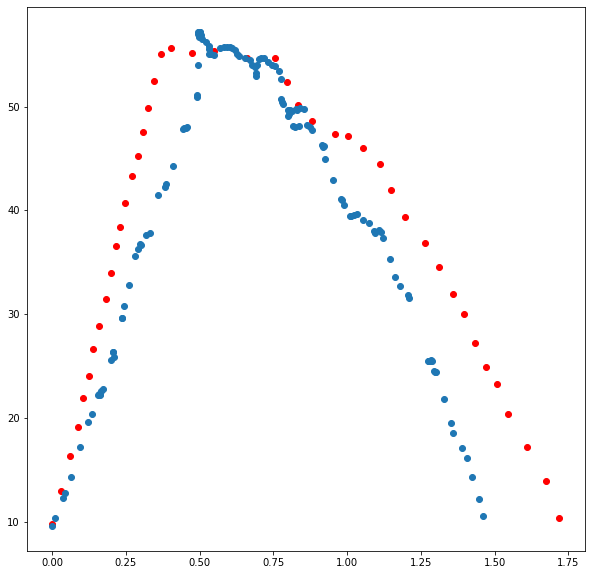

In [22]:

fig = plt.figure(constrained_layout = False, figsize=(10,10))

ss = SampleSet(ts)
X, Y = ss.getRawAvg()

Xc, Yc = sho(ts)

interpTime = np.linspace(0, Xc[-1], int(Xc[-1]/0.04)+1) # create time from 0 to median arrival time, evenly spaced 0.04s
interpPos = np.interp(interpTime, Xc, Yc) # interpolate the position at interpTime
plt.plot(interpTime, interpPos)

plt.scatter(X, Y, c="r")
plt.scatter(Xc, Yc)
print(interpTime, interpPos)

TypeError: 'NoneType' object is not iterable

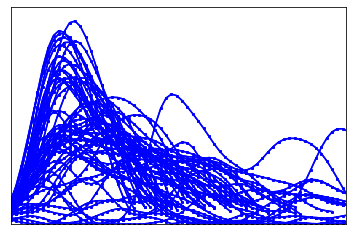

In [16]:
ax = plt.gca()
ss.pax(ax)

In [17]:
ss.getRawAvg()

(array([0.        , 0.0308644 , 0.06055252, 0.08631779, 0.10563063,
        0.12389245, 0.13955462, 0.15866833, 0.18158011, 0.20015253,
        0.21542504, 0.23063761, 0.24586441, 0.26961445, 0.29016238,
        0.30776015, 0.32521327, 0.34429387, 0.36804998, 0.40281353,
        0.47447036, 0.54697657, 0.66043307, 0.75678963, 0.79619647,
        0.83317918, 0.88066678, 0.95964468, 1.00373909, 1.05314847,
        1.11260604, 1.14756448, 1.19577458, 1.26277276, 1.31290437,
        1.35811449, 1.39674484, 1.43392842, 1.47190835, 1.50776831,
        1.5449767 , 1.60981756, 1.67281285, 1.72      ]),
 array([ 9.76050755, 12.95424106, 16.29003031, 19.14598784, 21.88439469,
        24.06664568, 26.68168117, 28.81780374, 31.409847  , 34.00188994,
        36.5939227 , 38.43957938, 40.72362987, 43.31594496, 45.23576707,
        47.55406499, 49.90131162, 52.4764256 , 55.05152644, 55.60935298,
        55.20258756, 55.38505052, 54.66275722, 54.63871352, 52.39729778,
        50.15573936, 48.63185573,